# Tutorial 2: Convolutional Neural Networks

In this tutorial we will focus on Convolutional Neural Networks (CNNs).  
We will train a model to label Brain MRI scans as either healthy or containing a tumor. 
We will use [Pytorch](https://pytorch.org/tutorials/recipes/recipes_index.html) and a [Pytorch Lightning](https://lightning.ai/docs/pytorch/stable/levels/core_skills.html) to build and train our model.  
The notebook will give you a framework with some parts of the code left blank. Fill in the missing code to make it work. 
It will be helpful to look up Pytorch or Lightning commands on the go. The packages usually offer easy-to-use methods for everything Deep Learning related. 

Before we start, let's explore how CNNs work in this [CNN visualizer](https://adamharley.com/nn_vis/cnn/3d.html)

## Step 0: Imports

Let's import all the Python modules that we need.

In [17]:
import os
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns 

# dealing with images
from PIL import Image

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import torchmetrics

# Pytorch Lightning
import lightning as L

# for visualization
import tensorboard

In [18]:
# check if we can use GPUs
torch.cuda.is_available()

True

## Step 1: Loading the data

Download the dataset from: https://polybox.ethz.ch/index.php/s/Tc8bCcx9accezYw

The dataset contains images of brain MRI scans. Some of them are from healthy patients, others from patients with brain tumors.  
We will train a model that can classify the images correctly.

Unzip the downloaded folder. 
Then, add the correct path in the cell below, pointing to the data. 

In [19]:
####### TODO #########
# enter the path of the data directory
data_dir = "/home/course/Documents/tutorial_mri_data" 

######################

# read the labels into a dataframe with pandas
labels_df = pd.read_csv(data_dir + "/metadata.csv", index_col=0)
labels_df

,image,class,format,mode,shape
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"
...,...,...,...,...,...
4595,Not Cancer (995).jpg,normal,JPEG,RGB,"(168, 300, 3)"
4596,Not Cancer (996).jpg,normal,JPEG,RGB,"(509, 452, 3)"
4597,Not Cancer (997).jpg,normal,JPEG,RGB,"(197, 177, 3)"
4598,Not Cancer (998).jpg,normal,JPEG,RGB,"(217, 232, 3)"


### Data exploration

How large is our dataset?
Plot the class distribution below:

Normal percentage: 45.37%
Tumor percentage: 54.63%


<Axes: xlabel='class', ylabel='Count'>

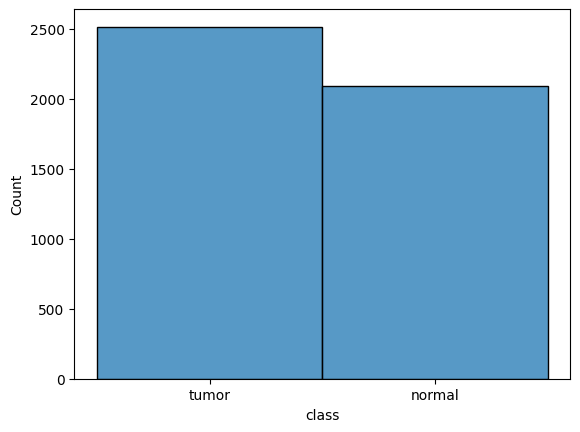

In [20]:
##### TODO ######
# get the percentage of normal and tumor classes in the dataset

normal_percentage = round(len(labels_df[labels_df["class"] == "normal"]) / len(labels_df) * 100, 2)
tumor_percentage = round(len(labels_df[labels_df["class"] == "tumor"]) / len(labels_df) * 100, 2)

#################

print("Normal percentage: {}%".format(normal_percentage))
print("Tumor percentage: {}%".format(tumor_percentage))

sns.histplot(labels_df, x="class")


Now, that we have loaded the labels, we will load the images.  
As we have seen above the images can have different file types and dimensions.   
Next we will load the data into datasets that we can use for training. 
To simplify training the models, we will transform the pictures, to the same size and normalize the data.

In [21]:
image_dir = data_dir + "/Brain Tumor Data Set/Brain Tumor Data Set/"
# seed everything 
torch.manual_seed(42) # set random seed to have reproducibility between the tutorials

# adding transforms to have same dimensions and some random rotations/flips to get more robust predictions
transform = transforms.Compose(
                [
                transforms.Resize((256,256)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(30),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225]) # from ImageNet
                ]  
            )

# load the complete dataset
full_dataset = torchvision.datasets.ImageFolder(image_dir, transform=transform) 

########## TODO ###############
# create the train val and test set, e.g. using a 70%, 15%, 15% split
# use a pytorch function to do this
train_set, val_set, test_set =  torch.utils.data.random_split(full_dataset, [0.70, 0.15, 0.15])

# define the dataloaders for train, validation and test (use shuffle for train only)
batch_size_train = 256
batch_size = 128 # for eval and test

# usinf DataLoader from Pytorch
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = 16)
val_loader = DataLoader(val_set,   batch_size=batch_size,       shuffle=False, num_workers=16)
train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True,  num_workers=16)
#num_workers specifies how many subprocesses to use for data loading in parallel.
###############################

Let's take a look at some of the images we have loaded.

In [22]:
# plots n random brain MRI images from the passed dataset
def plot_images(dataset, n=16):
    CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
    } 
    cols, rows = 4, int(np.ceil(n/4))
    figure = plt.figure(figsize=(10, 10))
    for i in range(1, n + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        # read out image and label from item
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(CLA_label[label])
        plt.axis("off")
        img_np = img.numpy().transpose((1, 2, 0))
        # Clip pixel values to [0, 1]
        img_valid_range = np.clip(img_np, 0, 1)
        plt.imshow(img_valid_range)
    plt.show()

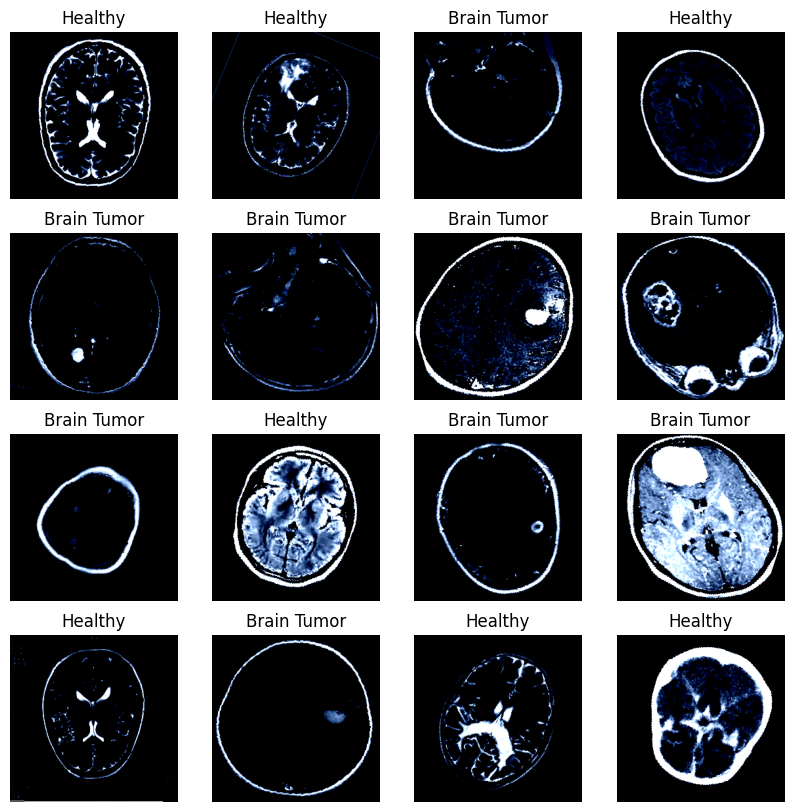

In [23]:
plot_images(train_set)

Under the hood the images are just vectors, though (here called tensors).  
In the dataset each item is saved together with it's label. 
The images in the dataset all have a size of 256x256 and 3 color channels (RBG). 

In [24]:
# PyTorch's Dataset classes (like ImageFolder or custom datasets) return items as tuples of (image, label) by convention.

# get first item from dataset, the item is just a tuple
first_item = train_set[0]

####### TODO #########
# get image at index 0 and label at index 1 from the item
image_tensor = first_item[0]
label = first_item[1]

# print the shape of the image tensor and the tensor 
print(image_tensor)
print("Shape: ", image_tensor.shape)
#####################

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

The above vector/tensor encodes the picture below.

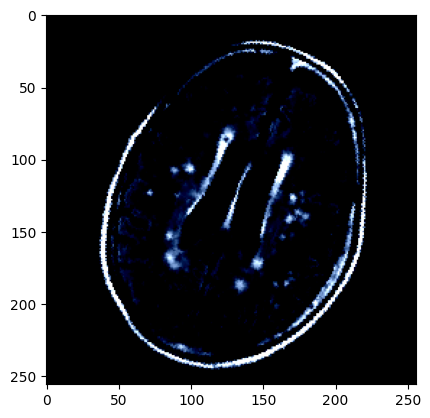

In [25]:
# showing tensor as image
img_valid_range = np.clip(image_tensor.numpy().transpose((1, 2, 0)), 0, 1)
plt.imshow(img_valid_range)

## Step 2: Creating a CNN architecture

Here is a recap of how convolutions work and CNNs work: https://www.pinecone.io/learn/series/image-search/cnn/

![CNN Overview](https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2Fb6337e9122efe9c56985302d3123951ddd237ee6-840x331.png&w=3840&q=75)

Also here: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53 


We are going to build a CNN now.

### Helper function

First we will only look into how the convolutional kernel works.

<video width="640" height="480" autoplay loop muted>
  <source src="https://d33wubrfki0l68.cloudfront.net/e661cd676eee2272e5231acd7011f7aee7f43dcf/b851e/images/cnn-6.mp4" type="video/mp4">
</video>

The function below computes the new dimensions of our data after convolution and max pooling.  
It will be helpful later when we build the model.

In [26]:
# get the output shape of our data after a convolution and pooling of a certain size

def get_conv2d_out_shape(tensor_shape, conv, pool=2):
    # return the new shape of the tensor after a convolution and pooling
    # tensor_shape: (channels, height, width)
    # convolution arguments
    kernel_size = conv.kernel_size
    stride=conv.stride # 2D array
    padding=conv.padding # 2D array
    dilation=conv.dilation # 2D array
    out_channels = conv.out_channels

    height_out = np.floor((tensor_shape[1]+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    width_out = np.floor((tensor_shape[2]+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
    
    if pool:
        # adjust dimensions to pooling
        height_out/=pool
        width_out/=pool
        
    return int(out_channels),int(height_out),int(width_out)

In [27]:
# some simple tests
t1 = torch.randn(3, 256, 256)
t2 = torch.randn(5, 256, 256)
conv1 = nn.Conv2d(in_channels=3, out_channels = 256, kernel_size=10)
conv2 = nn.Conv2d(in_channels=3, out_channels = 64, kernel_size=4)
conv3 = nn.Conv2d(in_channels=5, out_channels = 13, kernel_size=7)
print(get_conv2d_out_shape(t1.shape, conv1, pool=2))
print(get_conv2d_out_shape(t1.shape, conv2, pool=1))
print(get_conv2d_out_shape(t2.shape ,conv3, pool=2))

(256, 123, 123)
(64, 253, 253)
(13, 125, 125)


**Can you explain the output above? How does the size change after a convolution and why?**

Your answer: The spatial size shrinks after convolution, because the kernel cannot be centered on edge pixels, reducing the dimensions by kernel_size - 1. It shrinks further with pooling by dividing by the pool size.

Channels change to what out_channels is defined as.

### CNN Model

We can now build our Convolutional Neural Network. 
It will have two convolutional layers and two fully connected layers.  
You will be able to mostly use Pytorch methods to fill in the blanks. 

In [28]:
class MRIModel(nn.Module): # For each layer, we need to know their input and output dimensions
    
    def __init__(self, params):
        super(MRIModel, self).__init__()

        # Read parameters
        shape_in = params["shape_in"] # Expecting [C, H, W]
        channels_out = params["initial_depth"] 
        fc1_size = params["fc1_size"]
        
        # Max pooling layer (reusable)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        ## Conv layer 1
        self.conv1 = nn.Conv2d(shape_in[0], channels_out, kernel_size=8)
        # Calculate shape: Conv1 -> Pool
        current_data_shape = get_conv2d_out_shape(shape_in, self.conv1, pool=2)

        ## Conv layer 2
        # Input channels = previous output channels
        self.conv2 = nn.Conv2d(current_data_shape[0], current_data_shape[0] * 2, kernel_size=4)
        # Calculate shape: Conv2 -> Pool
        current_data_shape = get_conv2d_out_shape(current_data_shape, self.conv2, pool=2)

        #### Fully connected layers
        # Flattened size = Channels * Height * Width, convert 3 D dimensions into a 1 D dimension
        flat_size = current_data_shape[0] * current_data_shape[1] * current_data_shape[2]
        
        self.fc1 = nn.Linear(flat_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, 2)
        

    def forward(self, X):
        # Layer 1: Conv -> ReLU -> Pool
        X = self.pool(F.relu(self.conv1(X)))
        
        # Layer 2: Conv -> ReLU -> Pool 
        # (Added the missing pool to match your __init__ calculation)
        X = self.pool(F.relu(self.conv2(X)))

        # Flatten all dimensions except batch
        X = torch.flatten(X, 1) 

        # FC Layer 1 -> ReLU
        X = F.relu(self.fc1(X))
        
        # FC Layer 2 (Logits)
        X = self.fc2(X)

        # Output Log Softmax for classification
        return F.log_softmax(X, dim=1)

The code above is defining a class. This will allow us to create objects of that class. 

**What does ``self.`` do in the code? What is it good for in a class?**

Your answer: "self" stores variables on the object so they can be shared between methods. Without it, variables only exists locally inside one method and disappear after it finishes. A method is defined by "def" within a class.

Let's try an example and see how the model works.

In [29]:
# take first batch from the train loader
batch = next(iter(train_loader))[0]
# create the model
cnn_model = MRIModel(params={"shape_in":batch[0].shape,"initial_depth":4,"fc1_size":128})
# forward pass
out = cnn_model(batch)
# print shape of the input batch
print("Shape of the input batch: ", batch.shape)  # The first number is the batch size, the number of images in a batch.
# print the output shape
print("Shape of the output: ", out.shape)
# prediction output for first image, exp to get from log back to probabilities
print(torch.exp(out[0].detach()))

Shape of the input batch:  torch.Size([256, 3, 256, 256])
Shape of the output:  torch.Size([256, 2])
tensor([0.4813, 0.5187])


**Explain the shapes of the batch and the output shown above.**

Your answer:Shape of the input batch:  torch.Size([256, 3, 256, 256]) 256 images in the batch, each with 3 color channels (RGB), and spatial dimensions of 256*256 pixels.

256 predictions (one per image), each containing 2 log-probability values - one per class (binary classification)

**How do you interpret the prediction for the first image?**

Your answer: tensor([0.4649, 0.5351]) assigns 46.5% probability to class 0 and 53.5% to class 1 (softmax), summing to 1.

### Train and validation with Lightning

Now that we have created our model architecture, we will wrap a Lightning module around it. 
This will make the training procedure much easier.  
Instead of programming the whole training loops ourselves, we will define how one step should be handled at training, validation and testing.  
We only need to define how to retreive data from the batch, how to pass it through our model and how/when to compute the loss. 
The rest will be all handled by Lightning.  
Make sure to use the Lightning docs and Google, to find the right methods.  

In [30]:
import torch
from torch import nn
import torchmetrics
import lightning as L

class LitMRIModel(L.LightningModule):
    def __init__(self, model_parameters, learning_rate=1e-2):
        super().__init__()
        # 1. Save hyperparameters so they are available via self.hparams
        self.save_hyperparameters()
        
        # Create the underlying neural network model
        self.model = MRIModel(model_parameters)
        self.lr = learning_rate
        
        # define loss function
        self.loss_function = nn.NLLLoss(reduction="mean")
        
        # define accuracy metric
        self.accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=2)

    def training_step(self, batch, batch_idx):
        x, y = batch
        predictions = self.model(x)
        
        loss = self.loss_function(predictions, y)
        # It's better to use self.accuracy.update() or call it directly
        acc = self.accuracy(predictions, y)

        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        predictions = self.model(x)
        
        loss = self.loss_function(predictions, y)
        acc = self.accuracy(predictions, y)

        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        predictions = self.model(x)
        
        loss = self.loss_function(predictions, y)
        acc = self.accuracy(predictions, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        # FIX: Removed extra closing parenthesis after self.parameters()
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

### Visualization
To visualize the training procedure, we will use Tensorboard.  
In the code above we can see some values being logged. Tensorboard will display these values in nice graphs for us to follow our learning curves.

In [36]:
# create a tensorboard session
# new tab should open in your browser
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

## Step 3. Training and evaluating 

Now that everything is ready, we can start training the model.  
Make sure to follow its performance on Tensorboard. 

In [32]:
# define parameters
model_parameters={
        "shape_in": (3,256,256), # size of our images
        "initial_depth": 4,    
        "fc1_size": 128}

In [33]:
# train model
########## TODO #############
# initialize the lightning model with model_parameters and learning_rate=1e-3
# always do this before training, to have a new model
lighting_model = LitMRIModel(model_parameters, learning_rate=1e-3)
############################

# instantiate the lightning trainer 
trainer = L.Trainer(max_epochs=20, log_every_n_steps=1)
# train
trainer.fit(lighting_model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode  | FLOPs
--------------

Sanity Checking: |                                                                             | 0/? [00:00<?,…

/home/course/bc_deep_learning_in_biology/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Training: |                                                                                    | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

Validation: |                                                                                  | 0/? [00:00<?,…

`Trainer.fit` stopped: `max_epochs=20` reached.


If you get the message ``Error displaying widget`` stop jupyter lab, run ``conda uninstall ipywidgets`` in the terminal and start jupyter lab again.

Look at the learning curves in tensorboard. (You might need to click the refresh button on the website). 
Answer the following questions below. Write the answers in this cell.

1. How many steps are there in one epoch? How do you compute it?
There are 13 steps per epoch (visible in the progress bar 13/13). You compute it as:

steps per epoch = training set size / batch size

Your training set is ~70% of the dataset, and with batch_size=256, that gives 13 batches per epoch.

2. What is the difference between the metrics per step and per epoch?

Per-step metrics are computed on a single batch at that moment in training.


Per-epoch metrics are averaged over all batches in the entire epoch — they are smoother and more representative of overall performance.

4. Which metrics/graphs can help you understand whether your model is learning?


The most informative are train_loss and val_loss — if both decrease over epochs, the model is learning. train_acc and val_acc rising over time also confirms this. You want to watch both training and validation together.


6. How well did your model train? Would you improve something?


The model reached val_acc=0.890 and train_acc=0.921, which is decent. The small gap between train and val accuracy suggests mild overfitting. You could try training for more epochs, adding dropout layers, or data augmentation to improve further.


8. How could you see from the graphs if your model is overfitting?


Overfitting shows as train_loss continuing to decrease while val_loss stops decreasing or starts increasing. Similarly, train_acc keeps rising while val_acc plateaus or drops.

### Validate and visualize

Let us evaluate the model now. As we might still make changes, and tune parameters, we should not use the test set, yet. 
The test set is only for the final evaluation and should never be looked at before to ensure unbiased models.

In [ ]:
# Test the model on the validation set
trainer.validate(lighting_model, val_loader)

We will visualize our predictions in a confusion matrix to get a feeling of how well the model performs in specific cases. 

              precision    recall  f1-score   support

         0.0       0.89      0.92      0.91       390
         1.0       0.89      0.85      0.87       300

    accuracy                           0.89       690
   macro avg       0.89      0.89      0.89       690
weighted avg       0.89      0.89      0.89       690
 




<Axes: >

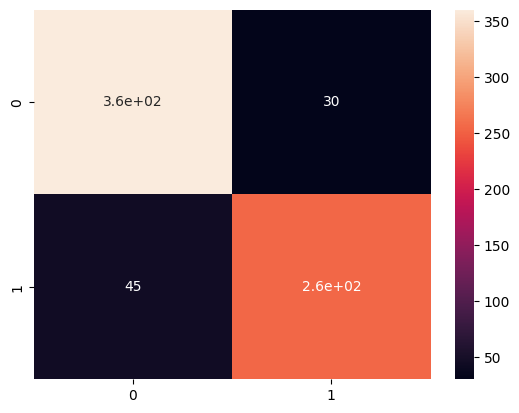

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

# get the predictions and plot a confusion matrix

# function to retrieve the predictions of the model and return them with the true labels
def get_predictions(val_loader, model):
    y_true = []
    y_pred = []

    for images, labels in val_loader:
        images = images#.to(device)
        labels = labels.numpy()
        outputs = model.model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()
        
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred

########## TODO #############
# get predictions from the cnn_model on the val_loader
y_true, y_pred = get_predictions(val_loader, lighting_model)
############################

# print summary
print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True)

**How does the information we get from the confusion matrix compare to what we can learn from the training curves?**

Your answer:

Training curves: Show whether the model is learning and generalizing over time (via loss/accuracy trends per epoch).

Confusion matrix: Shows the breakdown of specific errors after training, revealing which classes are confused and the clinical cost of each mistake type.

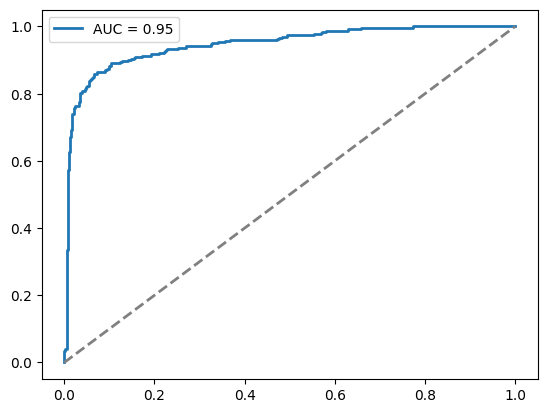

In [47]:
# Plot a ROC curve
# It plots the True Positive Rate (sensitivity) against the False Positive Rate (1-specificity) at every possible classification threshold. 
from sklearn.metrics import roc_curve, auc

# get predictions (as probabilities)
def get_prediction_probs(val_loader, model):
    y_true = []
    y_pred = []

    for images, labels in val_loader:
        images = images#.to(device)
        labels = labels.numpy()
        outputs = model.model(images)
        # exp() because we use log softmax as last layer
        # get the probabilities for tomor class 
        prediction_probabilities = torch.exp(outputs)[:,1] 
        pred = prediction_probabilities.detach().cpu().numpy()
    
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred

y_true, y_pred_probabilities = get_prediction_probs(val_loader, lighting_model)

########## TODO #############
# compute ROC curve and ROC area for each class
# use sklearn roc_curve and auc functions
fpr, tpr, _ = roc_curve(y_true, y_pred_probabilities)
roc_auc = auc(fpr, tpr)
##############################

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color="grey")
plt.legend()

In the U.S. 21.97 of 100,000 people are diagnosed with brain tumors.  
Assume a doctor uses our model to screen 100,000 persons from the U.S. 

**Based on the computed values above, how many healthy people do we expect to be wrongly diagnosed with brain cancer?**

Your answer: Based on the classification report, the model has a recall of 0.85 for the healthy class (class 1), meaning it misclassifies 15% of healthy people as having a tumor; since 100,000 − 22 = 99,978 people in the screening are healthy, we expect approximately 99,978 × 0.15 ≈ 14,997 healthy people to be wrongly diagnosed with brain cancer.

## Step 4: Improving

### Finetuning training parameters

The training procedure could use some improvements.  
Adjust the number of epochs, batch size and learning rate and rerun the model.  
Analyze how performance changes.  

In [42]:
# train a model with a large learning rate (e.g. 1e-1)
# make sure to name your lightning model variable in a way to not overwrite the previously trained model

########## TODO #############
# instantiate lightning model
model_large_lr = LitMRIModel(model_parameters, learning_rate=1e-1)
# define trainer, 20 epochs
trainer =L.Trainer(max_epochs=20, log_every_n_steps=1)
# train
trainer.fit(model_large_lr, train_loader, val_loader)
##############################


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | model         | MRIModel           | 3.7 M  | train | 0    
1 | loss_function | NLLLoss            | 0      | train | 0    
2 | accuracy      | MulticlassAccuracy | 0      | train | 0    
---------------------------------------------------------------------
3.7 M     Trainable params
0         Non-train

Sanity Checking: |                                      | 0/? [00:00<?, ?it/s]

/home/course/bc_deep_learning_in_biology/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Training: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [43]:
# train a model with a small learning rate (e.g. 1e-5)

########## TODO #############
# instantiate lightning model
model_small_lr = LitMRIModel(model_parameters, learning_rate=1e-5)
# define trainer, 20 epochs
trainer =  L.Trainer(max_epochs=20, log_every_n_steps=1)
# train
trainer.fit(model_small_lr, train_loader, val_loader)
##############################

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | model         | MRIModel           | 3.7 M  | train | 0    
1 | loss_function | NLLLoss            | 0      | train | 0    
2 | accuracy      | MulticlassAccuracy | 0      | train | 0    
---------------------------------------------------------------------
3.7 M     Trainable params
0         Non-train

Sanity Checking: |                                      | 0/? [00:00<?, ?it/s]

Training: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


**How does the learning rate influence training performance?**

Your answer: 

- Large LR (1e-1): The model barely learned — val_acc=0.565, barely above random chance (50%). The updates were too large, causing the model to overshoot optimal weights and fail to converge.
- Small LR (1e-5): Better but still poor — val_acc=0.800. The steps were so tiny that 20 epochs weren't enough to converge; given more epochs it would eventually improve.
- Original LR (1e-3): Best result — val_acc=0.890. A good balance between convergence speed and stability.


Let's use the original learning rate of 1e-3 again. 
Now we will change the batch size in the dataloaders

In [44]:
# lightning model
model_small_batches = LitMRIModel(model_parameters, learning_rate=1e-3)

#### TODO ####
## create train dataloader with a small batch size
train_loader_small =  DataLoader(train_set, batch_size=16, shuffle=True, num_workers=16)

# train model
trainer = L.Trainer(max_epochs=20, log_every_n_steps=1)
# train with smaller batch size
trainer.fit(model_small_batches, train_loader_small, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | model         | MRIModel           | 3.7 M  | train | 0    
1 | loss_function | NLLLoss            | 0      | train | 0    
2 | accuracy      | MulticlassAccuracy | 0      | train | 0    
---------------------------------------------------------------------
3.7 M     Trainable params
0         Non-train

Sanity Checking: |                                      | 0/? [00:00<?, ?it/s]

Training: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [45]:
# lightning model
model_big_batches = LitMRIModel(model_parameters, learning_rate=1e-3)

#### TODO ####
# train with a large batch size, what's the largest batch size you can use?
train_loader_big = DataLoader(train_set, batch_size=512, shuffle=True, num_workers=16)

# train model
trainer = L.Trainer(max_epochs=20, log_every_n_steps=1)
# train
trainer.fit(model_big_batches, train_loader_big, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | model         | MRIModel           | 3.7 M  | train | 0    
1 | loss_function | NLLLoss            | 0      | train | 0    
2 | accuracy      | MulticlassAccuracy | 0      | train | 0    
---------------------------------------------------------------------
3.7 M     Trainable params
0         Non-train

Sanity Checking: |                                      | 0/? [00:00<?, ?it/s]

Training: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


**How does the batch size influence the model performance?**

Your answer: 

- Smaller batch sizes yield better generalization because the noisier gradient estimates act as regularization, helping the model escape sharp minima and converge to flatter, more generalizable solutions. Larger batches produce more accurate but "sharper" gradient updates, often leading to worse test performance despite faster wall-clock training per epoch.

| Model | Batch Size | val_acc | val_loss |
|---|---|---|---|
| Small batch | 16 | 0.949 | 0.237 |
| Original | ~64 | 0.890 | 0.298 |
| Large batch | 512 | 0.857 | 0.346 |

- smaller batches generalize better, with the small-batch model outperforming the original by ~6% val_acc. The original already improves over large batches, showing that even a moderate reduction in batch size provides meaningful regularization benefit.

Now let's train for more epochs.

In [46]:
# lightning model
model_long_training = LitMRIModel(model_parameters, learning_rate=1e-3)

# train the model for 100 epochs
trainer = L.Trainer(max_epochs=100, log_every_n_steps=1)
# train on train_loader again
trainer.fit(model_long_training, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | model         | MRIModel           | 3.7 M  | train | 0    
1 | loss_function | NLLLoss            | 0      | train | 0    
2 | accuracy      | MulticlassAccuracy | 0      | train | 0    
---------------------------------------------------------------------
3.7 M     Trainable params
0         Non-train

Sanity Checking: |                                      | 0/? [00:00<?, ?it/s]

Training: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


**How does the model perform? How do more epochs influence performance and how many epochs are enough?**

Your answer:**More epochs improved val_acc but at the cost of overfitting — the model memorizes training data (0.998) while generalization lags behind. Remedies would include early stopping, dropout, or regularization.**

| Model        | Epochs | val_acc | val_loss | train_acc |
|---|---|---|---|---|
| Original     | 20     | 0.890   | 0.298    | 0.921     |
| Small batch  | 20     | 0.949   | 0.237    | 0.977     |
| Long training| 100    | 0.965   | 0.330    | 0.998     |

### Model improvements (optional)

Simply finding the best training parameters improves the performance to some degree.  
Especially in more complex problems and with larger datasets the architecture and the amount and size of the layers also matter. 
Now you can experiment with the CNN architecture. 
Use the code from a bove and **create a deeper or larger model (Eg. 4 conv layers and 2 fully connected)**.  
Or simply experiment around with the model parameters. Maybe use different kernel sizes. Try to see if you can further improve the preformance.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | model         | MRIModel           | 1.1 M  | train | 0    
1 | loss_function | NLLLoss            | 0      | train | 0    
2 | accuracy      | MulticlassAccuracy | 0      | train | 0    
---------------------------------------------------------------------
1.1 M     Trainable params
0         Non-train

Sanity Checking: |                                      | 0/? [00:00<?, ?it/s]

/home/course/bc_deep_learning_in_biology/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Training: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

Validation: |                                           | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                           | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8710144758224487
        val_loss            0.33377182483673096
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

         0.0       0.94      0.84      0.89       390
         1.0       0.81      0.93      0.87       300

    accuracy                           0.88       690
   macro avg       0.88      0.88      0.88       690
weighted avg       0.89      0.88      0.88       690
 




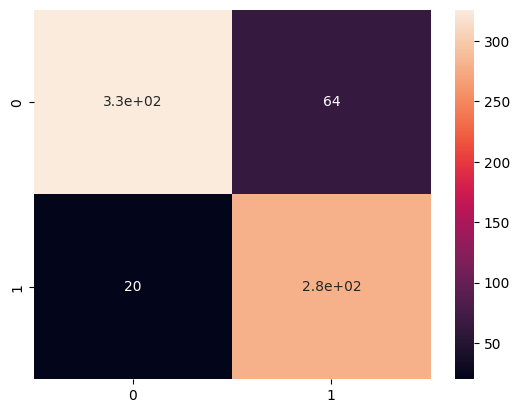

In [49]:
class MRIModel(nn.Module):
    
    def __init__(self, params):
        super(MRIModel, self).__init__()

        # Read parameters
        shape_in = params["shape_in"]
        channels_out = params["initial_depth"] 
        fc1_size = params["fc1_size"]
        
        # Max pooling layer (reusable)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        ## Conv layer 1
        self.conv1 = nn.Conv2d(shape_in[0], channels_out, kernel_size=3, padding=1)
        current_data_shape = get_conv2d_out_shape(shape_in, self.conv1, pool=2)

        ## Conv layer 2
        self.conv2 = nn.Conv2d(current_data_shape[0], current_data_shape[0] * 2, kernel_size=3, padding=1)
        current_data_shape = get_conv2d_out_shape(current_data_shape, self.conv2, pool=2)

        ## Conv layer 3
        self.conv3 = nn.Conv2d(current_data_shape[0], current_data_shape[0] * 2, kernel_size=3, padding=1)
        current_data_shape = get_conv2d_out_shape(current_data_shape, self.conv3, pool=2)

        ## Conv layer 4
        self.conv4 = nn.Conv2d(current_data_shape[0], current_data_shape[0] * 2, kernel_size=3, padding=1)
        current_data_shape = get_conv2d_out_shape(current_data_shape, self.conv4, pool=2)

        # Fully connected layers
        flat_size = current_data_shape[0] * current_data_shape[1] * current_data_shape[2]
        self.fc1 = nn.Linear(flat_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, 2)

    def forward(self, X):
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.pool(F.relu(self.conv3(X)))
        X = self.pool(F.relu(self.conv4(X)))
        X = torch.flatten(X, 1)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)


# --- Training ---
model_parameters = {
    "shape_in": (3, 256, 256),
    "initial_depth": 4,
    "fc1_size": 128
}

lighting_model = LitMRIModel(model_parameters, learning_rate=1e-3)
trainer = L.Trainer(max_epochs=20, log_every_n_steps=1)
trainer.fit(lighting_model, train_loader, val_loader)

# --- Validation ---
trainer.validate(lighting_model, val_loader)

# --- Predictions & Confusion Matrix ---
from sklearn.metrics import classification_report, confusion_matrix

def get_predictions(val_loader, model):
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        labels = labels.numpy()
        outputs = model.model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    return y_true, y_pred

y_true, y_pred = get_predictions(val_loader, lighting_model)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

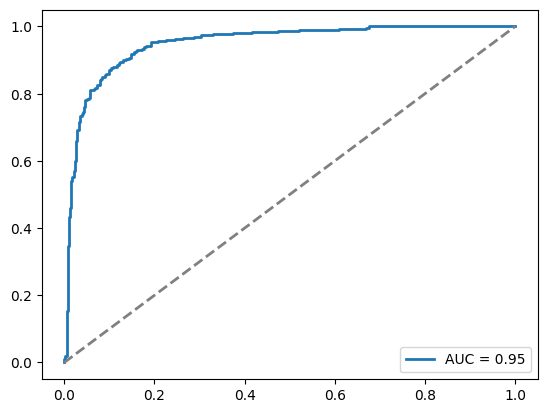

In [50]:
# Plot a ROC curve
# It plots the True Positive Rate (sensitivity) against the False Positive Rate (1-specificity) at every possible classification threshold. 
from sklearn.metrics import roc_curve, auc

# get predictions (as probabilities)
def get_prediction_probs(val_loader, model):
    y_true = []
    y_pred = []

    for images, labels in val_loader:
        images = images#.to(device)
        labels = labels.numpy()
        outputs = model.model(images)
        # exp() because we use log softmax as last layer
        # get the probabilities for tomor class 
        prediction_probabilities = torch.exp(outputs)[:,1] 
        pred = prediction_probabilities.detach().cpu().numpy()
    
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred

y_true, y_pred_probabilities = get_prediction_probs(val_loader, lighting_model)

########## TODO #############
# compute ROC curve and ROC area for each class
# use sklearn roc_curve and auc functions
fpr, tpr, _ = roc_curve(y_true, y_pred_probabilities)
roc_auc = auc(fpr, tpr)
##############################

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color="grey")
plt.legend()

## Step 5: Final testing

Now that we have a well performing model, we can run the model on the test set and see how it performs on unseen data.
This is only done at the very end. Never use the test data during training!

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/course/bc_deep_learning_in_biology/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Testing: |                                              | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.960869550704956
        test_loss           0.18825946748256683
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       378
         1.0       0.94      0.96      0.95       312

    accuracy                           0.96       690
   macro avg       0.96      0.96      0.96       690
weighted avg       0.96      0.96      0.96       690
 




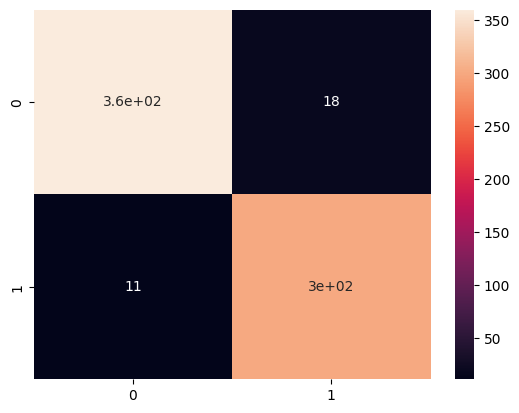

In [51]:
# pass the best performing model here
best_model = model_small_batches

# test your best performing model on the test set
trainer.test(best_model, test_loader)

# print the confusion matrix and classification report
y_true, y_pred = get_predictions(test_loader, best_model)
print(classification_report(y_true, y_pred), '\n\n')

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True)
plt.show()